<a href="https://colab.research.google.com/github/NatashaKhotkina/Amino_acid_transfer_learning_for_antibody_binding_prediction/blob/main/Transfer_learning_for_AB_binding_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and settings

In [1]:
!git clone https://github.com/NatashaKhotkina/Amino_acid_transfer_learning_for_antibody_binding_prediction.git
!mv Amino_acid_transfer_learning_for_antibody_binding_prediction/* .
!rm -rf Amino_acid_transfer_learning_for_antibody_binding_prediction

Cloning into 'Amino_acid_transfer_learning_for_antibody_binding_prediction'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 145 (delta 69), reused 95 (delta 29), pack-reused 0
Receiving objects: 100% (145/145), 9.54 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [3]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold

from src.dataset import make_dataloader
from src.models import LSTMModel, LSTMMultiModel
from src.train import train_model, train_multi_model
from src.validate import eval_model

In [4]:
plt.rcParams["figure.figsize"] = 12, 9
plt.rcParams["font.size"] = 20
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cuda:0


# Code for model pretraining - skip it

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
batch_size=256

In [ ]:
train_ace2 = pd.read_csv("/content/gdrive/MyDrive/BI_project/ACE2_train_data.csv")
test_ace2 = pd.read_csv("/content/gdrive/MyDrive/BI_project/ACE2_test_data.csv")

In [ ]:
train_ace2.shape

(406886, 5)

In [ ]:
trainloader_ace2 = make_dataloader(train_ace2, batch_size=batch_size, shuffle=True)
testloader_ace2 = make_dataloader(test_ace2, batch_size=batch_size, shuffle=False)

In [ ]:
lstm_pretrained_ace2 =  LSTMModel(input_size=20, hidden_size=80, num_layers=3, dropout=0.2).to(device)

train_model(model=lstm_pretrained_ace2, trainload=trainloader_ace2, num_epochs=10, 
            learning_rate=0.001, criterion=nn.BCEWithLogitsLoss, optim=torch.optim.Adam, print_epoch=True)

In [ ]:
torch.save(lstm_pretrained_ace2.state_dict(), "lstm_pretrained_ace2.pt")

# Reading data

In [5]:
batch_size=256

In [6]:
train_ly16 = pd.read_csv("data/LY16_train_data.csv")
test_ly16 = pd.read_csv("data/LY16_test_data.csv")

In [7]:
trainloader_ly16 = make_dataloader(train_ly16, batch_size=batch_size, shuffle=True)
testloader_ly16 = make_dataloader(test_ly16, batch_size=batch_size, shuffle=False)

# HP optimization with Optuna

Here we search for best training hyperparametrs - learning rate and number of epochs.

In [8]:
pretrained_path = "models/lstm_pretrained_ace2.pt"

In [9]:
whole_dataset_len = len(train_ly16)
train_ly16_small, _ = train_test_split(train_ly16, train_size=1000 / whole_dataset_len, 
                                       random_state=SEED, stratify=train_ly16['Label'])

In [10]:
batch_size = 256
def objective(trial, train_loader, valid_loader):
    param = {
        "num_epochs": trial.suggest_int("num_epochs", 20, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.01),
    }
    lstm =  LSTMModel(input_size = 20, hidden_size = 80, num_layers=3, dropout=0.2)
    lstm = lstm.to(device)

    lstm.load_state_dict(torch.load(pretrained_path))

    train_model(model=lstm, trainload=train_loader, num_epochs=param["num_epochs"], 
                learning_rate=param["learning_rate"], criterion=nn.BCEWithLogitsLoss, 
                optim=torch.optim.Adam, print_epoch=False, device=device)
    
    *_, mean_roc_auc = eval_model(model=lstm, testload=valid_loader, device=device)

    return mean_roc_auc


def objective_cv(trial):

    fold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []
    for cv_number, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_ly16_small)))):
        train_data = train_ly16_small.iloc[train_idx, :]
        valid_data = train_ly16_small.iloc[valid_idx, :]

        train_loader = make_dataloader(train_data, batch_size=batch_size, shuffle=True)

        valid_loader = make_dataloader(valid_data, batch_size=batch_size, shuffle=True)

        roc_auc = objective(trial, train_loader, valid_loader)
        scores.append(roc_auc)

        trial.report(roc_auc, cv_number)

        if trial.should_prune():  # Stop trial if the metric for this epoch is bad.
            raise optuna.TrialPruned()

    return np.mean(scores)

In [11]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective_cv, n_trials=100)

#clear_output()

[I 2023-05-21 18:47:24,184] A new study created in memory with name: no-name-f3c94fe7-ea4c-4070-a83e-101a2e363403
[I 2023-05-21 18:48:27,470] Trial 0 finished with value: 0.8504471288558001 and parameters: {'num_epochs': 542, 'learning_rate': 0.0071044075037783455}. Best is trial 0 with value: 0.8504471288558001.
[I 2023-05-21 18:48:44,870] Trial 1 finished with value: 0.8362722974425102 and parameters: {'num_epochs': 180, 'learning_rate': 0.006509102446234377}. Best is trial 0 with value: 0.8504471288558001.
[I 2023-05-21 18:49:24,616] Trial 2 finished with value: 0.8478394949089451 and parameters: {'num_epochs': 416, 'learning_rate': 0.0052762856073056575}. Best is trial 0 with value: 0.8504471288558001.
[I 2023-05-21 18:50:52,564] Trial 3 finished with value: 0.8473223280577757 and parameters: {'num_epochs': 906, 'learning_rate': 0.0028869537134031857}. Best is trial 0 with value: 0.8504471288558001.
[I 2023-05-21 18:51:27,359] Trial 4 finished with value: 0.8532875280302017 and par

In [13]:
study.best_params, study.best_value

({'num_epochs': 21, 'learning_rate': 0.004760709555638973}, 0.8815193119472526)

# Comparing models with and without pretraining

In [14]:
pretrained_path = "models/lstm_pretrained_ace2.pt"

In [ ]:
batch_size = 256
dict_accuracy = defaultdict(list)
dict_precision = defaultdict(list)
dict_recall = defaultdict(list)
dict_f1  = defaultdict(list)
dict_roc_auc = defaultdict(list)

train_types = ['basic', 'pretrained']

whole_dataset_len = len(train_ly16)

for _ in range(40):
    print(_)
    train_small, _ = train_test_split(train_ly16, train_size=1000 / whole_dataset_len, 
                                          random_state=SEED, stratify=train_ly16['Label'])
    trainloader_ly16 = make_dataloader(train_small, batch_size=batch_size, shuffle=True)

    for train_type in train_types:
        if train_type == 'basic':
            lstm =  LSTMModel(input_size=20, hidden_size=80, num_layers=3, dropout=0.2).to(device)
            train_model(num_epochs=568, learning_rate=0.004568420560776651,
                        model=lstm, trainload=trainloader_ly16,
                        criterion=nn.BCEWithLogitsLoss, optim=torch.optim.Adam, print_epoch=False, device=device)
            
            mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc = eval_model(model=lstm, testload=testloader_ly16, 
                                                                                           device=device)
            
        elif train_type == 'pretrained':
            lstm =  LSTMModel(input_size=20, hidden_size=80, num_layers=3, dropout=0.2).to(device)

            lstm.load_state_dict(torch.load(pretrained_path))

            train_model(num_epochs=21, learning_rate=0.004760709555638973,
                        model=lstm, trainload=trainloader_ly16,
                        criterion=nn.BCEWithLogitsLoss, optim=torch.optim.Adam, print_epoch=False, device=device)
            
            mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc = eval_model(model=lstm, testload=testloader_ly16, 
                                                                                           device=device)

        dict_accuracy[train_type].append(mean_accuracy)
        dict_precision[train_type].append(mean_precision)
        dict_recall[train_type].append(mean_recall)
        dict_f1[train_type].append(mean_f1)
        dict_roc_auc[train_type].append(mean_roc_auc)

In [16]:
metric_dicts = [dict_accuracy, dict_precision, dict_recall, dict_f1, dict_roc_auc]

In [17]:
for metric_dict in metric_dicts:
    for name, values in metric_dict.items():
        print(name, np.mean(values))

basic 0.7969272070693225
pretrained 0.8294700577942251
basic 0.795974312456355
pretrained 0.8327620091895389
basic 0.7937561932596542
pretrained 0.8244411105519267
basic 0.7940371178800795
pretrained 0.8261121268334535
basic 0.8687820936443653
pretrained 0.9028050811917019


In [18]:
from scipy.stats import ttest_rel

In [19]:
pvalue = ttest_rel(dict_roc_auc['basic'], dict_roc_auc['pretrained']).pvalue

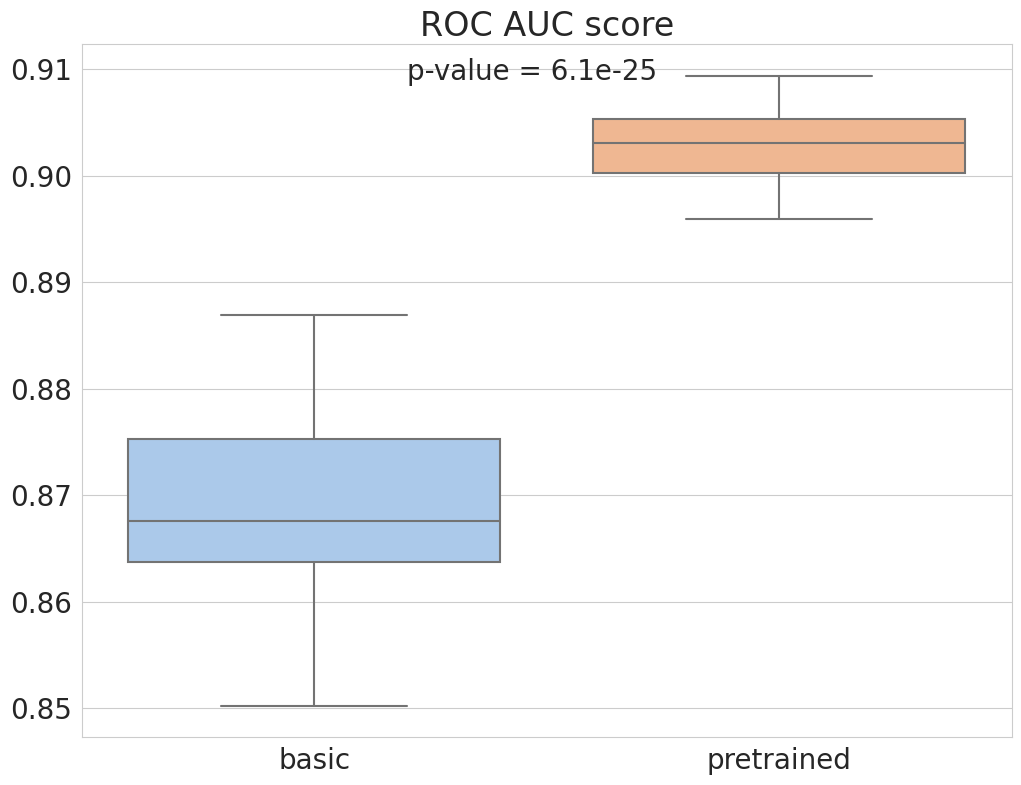

In [22]:
sns.boxplot(pd.DataFrame(dict_roc_auc), palette="pastel", showfliers=False)
#plt.ylim(0.86, 0.9)
plt.title("ROC AUC score")
plt.text(0.2, 0.909, f"p-value = {pvalue:.1e}")
plt.savefig("roc_auc_transfer_learning.png")

## Save metrics to json

In [ ]:
import json
from google.colab import files

In [ ]:
with open("accuracy.json", "w") as write_file:
    json.dump(dict_accuracy, write_file)

with open("precision.json", "w") as write_file:
    json.dump(dict_precision, write_file)

with open("recall.json", "w") as write_file:
    json.dump(dict_recall, write_file)

with open("f1.json", "w") as write_file:
    json.dump(dict_f1, write_file)

with open("roc_auc.json", "w") as write_file:
    json.dump(dict_roc_auc, write_file)

In [ ]:
files.download("accuracy.json")
files.download("precision.json")
files.download("recall.json")
files.download("f1.json")
files.download("roc_auc.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>